In [ ]:
## global parameters:
conservativeness_level = 0.5
starting_node = 0
starting_propagation_at_tick = 5000
propagation_interval = 20

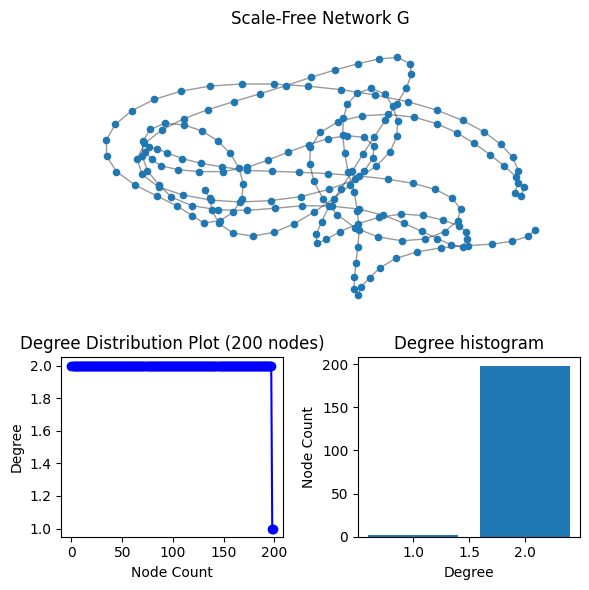

In [ ]:
import networkx as nx
import json
import matplotlib.pyplot as plt
import numpy as np

# none for using default topology, str for using simulation config file
simulation_config = None

def generate_default_graph():
    line_graph_N = 200
    edges = []
    for i in range(line_graph_N-1):
        edges.append((i,i+1))
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

def load_simulation_config(config_file_path: str):
    config_file = open(config_file_path)
    config_file_content = config_file.read()
    config_file_json = json.loads(config_file_content)
    topology = config_file_json['node_topology']
    G = nx.Graph()
    for singleItem in topology:
        unDirLink = singleItem.split('--')
        if len(unDirLink) != 1:
            G.add_edge(unDirLink[0], unDirLink[1])
    return G

def save_network_info(graph: nx.Graph, enable_topology: bool = False):
    degree_sequence = sorted((d for n, d in graph.degree()), reverse=True)

    if enable_topology:
        fig = plt.figure("Degree of a random graph", figsize=(6, 6))
        axgrid = fig.add_gridspec(5, 4)
        ax0 = fig.add_subplot(axgrid[0:3, :])
        ax1 = fig.add_subplot(axgrid[3:, :2])
        ax2 = fig.add_subplot(axgrid[3:, 2:])
    else:
        fig = plt.figure("Degree of a random graph", figsize=(6, 3))
        axgrid = fig.add_gridspec(2, 4)
        ax1 = fig.add_subplot(axgrid[:, :2])
        ax2 = fig.add_subplot(axgrid[:, 2:])

    if enable_topology:
        Gcc = graph.subgraph(sorted(nx.connected_components(graph), key=len, reverse=True)[0])
        pos = nx.spring_layout(Gcc, seed=10396953)
        nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
        nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
        ax0.set_title("Scale-Free Network G")
        ax0.set_axis_off()

    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Distribution Plot ({size} nodes)".format(size=len(graph.nodes)))
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Node Count")

    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("Node Count")

    fig.tight_layout()


if simulation_config is None:
    G = generate_default_graph()
else:
    G = load_simulation_config(simulation_config)
save_network_info(G, True)

In [ ]:
## get adjacent matrix
adjacent_matrix = nx.adjacency_matrix(G)
adjacent_matrix = adjacent_matrix.todense()
print(adjacent_matrix)

[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]


In [ ]:
network_size = len(G.nodes)
transformation_matrix = np.zeros((network_size, network_size))
for single_node in G.nodes:
    if starting_node == single_node:
        transformation_matrix[starting_node,starting_node] = 1
    else:
        non_zero_count = np.count_nonzero(adjacent_matrix[single_node])
        self_weight = conservativeness_level
        whole_other_weight = 1 - conservativeness_level
        single_other_weight = whole_other_weight / non_zero_count
        transformation_matrix[single_node] = adjacent_matrix[single_node] * single_other_weight
        transformation_matrix[single_node,single_node] = self_weight

print(transformation_matrix)

[[1.   0.   0.   ... 0.   0.   0.  ]
 [0.25 0.5  0.25 ... 0.   0.   0.  ]
 [0.   0.25 0.5  ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.5  0.25 0.  ]
 [0.   0.   0.   ... 0.25 0.5  0.25]
 [0.   0.   0.   ... 0.   0.5  0.5 ]]


In [ ]:
import pandas as pd

def calculate_proportion(transformation_matrix, time, nodes, src_node_index):
    transformation_matrix_powers = np.linalg.matrix_power(transformation_matrix, time)
    output = {}
    for node in nodes:
        output[node] = transformation_matrix_powers[node, src_node_index]
    return output


def calculate_proportion_to_csv(transformation_matrix, time, nodes, src_node_index, csv_file_name):
    output = pd.DataFrame()

    for t in time:
        row = calculate_proportion(transformation_matrix, t, nodes, src_node_index)
        row["time"] = t
        row_pd = pd.DataFrame(row, index=[0])
        output = pd.concat([output, row_pd], ignore_index=True)
    output.set_index("time", inplace=True)

    output.to_csv(f"{csv_file_name}.csv")
    return output


df = calculate_proportion_to_csv(transformation_matrix, list(range(10000)), list(range(50)), 0, "save")


In [ ]:
from google.colab import files
files.download('save.csv')

<Axes: xlabel='time'>

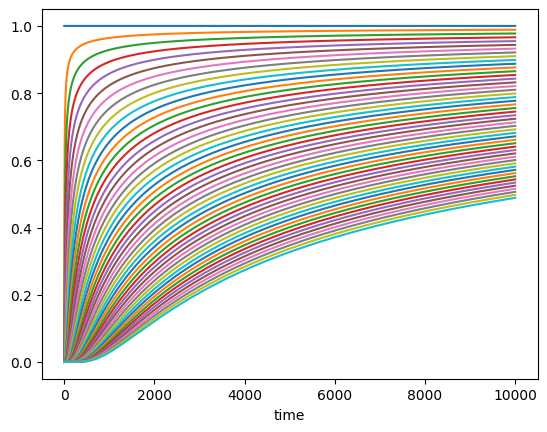

In [ ]:
df.plot(legend=False)

<Axes: xlabel='time'>

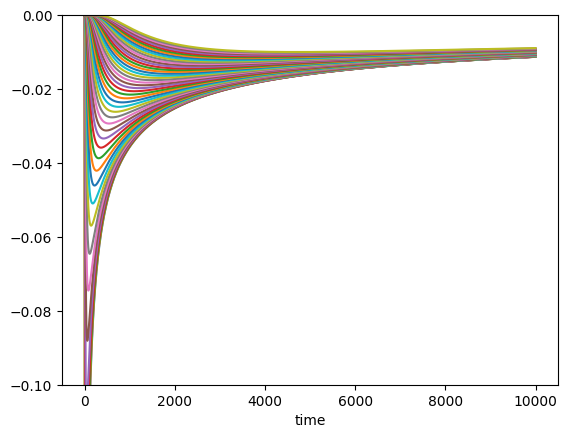

In [ ]:
difference_df = df.diff(axis=1)  # Difference along columns
difference_df.drop(columns=0, inplace=True)  # Drop the first column as it will be all NaN
difference_df.plot(legend=False, ylim=[-0.1,0])

<Axes: xlabel='time'>

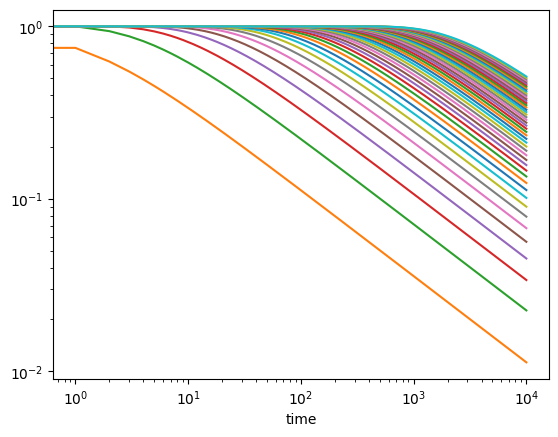

In [ ]:
new_df = 1- df
new_df.plot(legend=False, logy=True, logx=True)